In [9]:
import os
import re
import random
import numpy as np
import torch
import torchvision
from time import time
from tqdm import tqdm # progress bar
from sklearn.model_selection import train_test_split # Dividing train test
from nltk.translate.bleu_score import corpus_bleu # BLEU Score
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [10]:
import torch_directml
device = torch_directml.device()

In [11]:
dataset_path = "data"
dataset_images_path = dataset_path + "/Images/" 

In [12]:
img_height = 180
img_width = 180
validation_split = 0.2

In [39]:
def get_preprocessed_caption(caption):
    caption = re.sub(r'\s+', ' ', caption)
    caption = caption.strip()
    caption = "<start> " + caption + " <end>"
    return caption

In [27]:
# Diccionario: key-filename, value-caption_list,
subset = 0
images_captions_dict = {}

with open(dataset_path + "/captions.txt", "r") as dataset_info:
    next(dataset_info) # Omit header: image, caption

    # Using All
    for info_raw in list(dataset_info):
        info = info_raw.split(",")
        image_filename = info[0]
        caption = get_preprocessed_caption(info[1])

        if image_filename not in images_captions_dict.keys():
            images_captions_dict[image_filename] = [caption]
        else:
            images_captions_dict[image_filename].append(caption)

In [28]:
# Función de lectura de imagen
def load_image(image_path):
    img = torchvision.io.read_image(dataset_images_path+image_path) # Imagen de 3 x3...x500
    img = torchvision.transforms.functional.resize(img, size=[img_height, img_width])
    img = torch.permute(img, dims=[1,2,0])
    # Change values from 0/255 to 0/1
    img = img/255
    return img.numpy()
    



/home/raul/miniconda3/envs/directml-pytorch/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


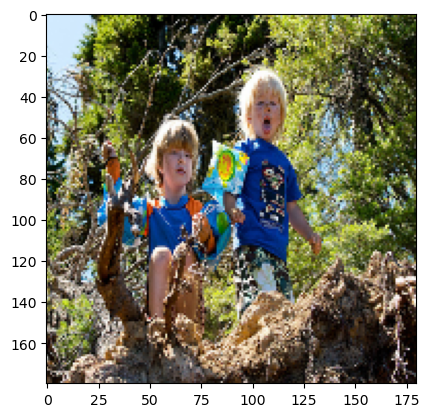

In [29]:
# Some testing
dataset_images_path = 'data/Images/'
image = '667626_18933d713e.jpg'
image = '3737539561_d1dc161040.jpg'
img = load_image(image)
plt.imshow(img)

In [56]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, root_path, images_captions_keys, transforms=None):
        self.root_dir = root_path
        self.image_paths = images_captions_keys
        self.transforms = transforms
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img = load_image(self.image_paths[idx])
        if self.transforms:
            img = self.transforms(img)
        
        return img, self.image_paths[idx]
    
    
    

In [63]:
# Crear dataset de imagenes
image_captions_dict_keys = list(images_captions_dict.keys())
image_dataset = ImageDataset(root_path=dataset_images_path, images_captions_keys=image_captions_dict_keys, transforms=None)
# Create data loader
image_dataset = DataLoader(image_dataset, batch_size=1, shuffle=True)


In [64]:
def get_encoder():
    # Mismo encoder que el de ejemplo
    image_model = torchvision.models.inception_v3(pretrained=True)
    # Habria que poner el no grad
    input = list(image_model.children())
    modules = list(image_model.children())[-1]
    return torch.nn.Sequential(*[modules])

In [ ]:


images_dict =  {}
encoder = get_encoder()
for img_tensor, path_tensor in tqdm(image_dataset):
    with torch.no_grad():
        batch_features_tensor = encoder(img_tensor)
    for batch_fratures, path in zip(batch_features_tensor, path_tensor):
        decode_path = path.numpy().decode('utf-8')
        images_dict[decode_path] = batch_fratures.numpy


In [70]:
i, p = next(iter(image_dataset))
print(i.shape)
encoder = get_encoder()
encoder(i)

/home/raul/miniconda3/envs/directml-pytorch/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/raul/miniconda3/envs/directml-pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(

torch.Size([1, 180, 180, 3])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32400x3 and 2048x1000)